In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tqdm import tqdm

In [35]:
# Đường dẫn tới dữ liệu đã phân chia
DATA_DIR = Path("data/splits")
PROCESSED_DIR = Path("data/processed")
AUGMENTED_DIR = Path("data/augmented")
CLASSES = ["Brown_Spot", "Leaf_Blast", "Leaf_Blight", "Healthy"]
SPLITS = ["train", "val", "test"]

# Kích thước chuẩn hóa ảnh
TARGET_SIZE = (224, 224)  # Kích thước phổ biến cho nhiều mô hình CNN


In [36]:
def create_directories():
    """Tạo thư mục cho dữ liệu đã tiền xử lý và tăng cường"""
    for dir_path in [PROCESSED_DIR, AUGMENTED_DIR]:
        for split in SPLITS:
            for cls in CLASSES:
                path = dir_path / split / cls
                path.mkdir(parents=True, exist_ok=True)
                print(f"Đã tạo thư mục: {path}")

def preprocess_images():
    """Tiền xử lý ảnh: thay đổi kích thước, chuẩn hóa, tăng cường độ tương phản"""
    total_processed = 0
    
    for split in SPLITS:
        for cls in CLASSES:
            src_dir = DATA_DIR / split / cls
            dst_dir = PROCESSED_DIR / split / cls
            
            if not src_dir.exists():
                print(f"Thư mục không tồn tại: {src_dir}")
                continue
                
            files = list(src_dir.glob("*"))
            print(f"Đang xử lý {len(files)} ảnh từ {split}/{cls}...")
            
            for img_path in tqdm(files, desc=f"{split}/{cls}"):
                try:
                    # Đọc ảnh
                    img = cv2.imread(str(img_path))
                    if img is None:
                        print(f"Không thể đọc ảnh: {img_path}")
                        continue
                    
                    # Thay đổi kích thước với phương pháp nội suy tốt hơn cho ảnh nhỏ
                    # Sử dụng INTER_CUBIC cho ảnh nhỏ hơn TARGET_SIZE, INTER_AREA cho ảnh lớn hơn
                    h, w = img.shape[:2]
                    if h < TARGET_SIZE[0] or w < TARGET_SIZE[1]:
                        # Nội suy cubic tốt hơn cho phóng to
                        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_CUBIC)
                    else:
                        # Nội suy area tốt hơn cho thu nhỏ
                        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
                    
                    # Chuẩn hóa độ sáng và tương phản
                    # Chuyển sang không gian màu LAB để xử lý kênh sáng
                    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
                    l, a, b = cv2.split(lab)
                    
                    # Áp dụng CLAHE (Contrast Limited Adaptive Histogram Equalization)
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                    l = clahe.apply(l)
                    
                    # Ghép lại các kênh
                    lab = cv2.merge((l, a, b))
                    img_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
                    
                    # Giảm nhiễu (tùy chọn)
                    img_enhanced = cv2.fastNlMeansDenoisingColored(img_enhanced, None, 10, 10, 7, 21)
                    
                    # Tăng độ sắc nét (tùy chọn)
                    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
                    img_enhanced = cv2.filter2D(img_enhanced, -1, kernel)
                    
                    # Lưu ảnh đã xử lý
                    output_path = dst_dir / img_path.name
                    cv2.imwrite(str(output_path), img_enhanced)
                    total_processed += 1
                    
                except Exception as e:
                    print(f"Lỗi khi xử lý {img_path}: {e}")
    
    print(f"Đã xử lý tổng cộng {total_processed} ảnh")

In [37]:
create_directories()

Đã tạo thư mục: data/processed/train/Brown_Spot
Đã tạo thư mục: data/processed/train/Leaf_Blast
Đã tạo thư mục: data/processed/train/Leaf_Blight
Đã tạo thư mục: data/processed/train/Healthy
Đã tạo thư mục: data/processed/val/Brown_Spot
Đã tạo thư mục: data/processed/val/Leaf_Blast
Đã tạo thư mục: data/processed/val/Leaf_Blight
Đã tạo thư mục: data/processed/val/Healthy
Đã tạo thư mục: data/processed/test/Brown_Spot
Đã tạo thư mục: data/processed/test/Leaf_Blast
Đã tạo thư mục: data/processed/test/Leaf_Blight
Đã tạo thư mục: data/processed/test/Healthy
Đã tạo thư mục: data/augmented/train/Brown_Spot
Đã tạo thư mục: data/augmented/train/Leaf_Blast
Đã tạo thư mục: data/augmented/train/Leaf_Blight
Đã tạo thư mục: data/augmented/train/Healthy
Đã tạo thư mục: data/augmented/val/Brown_Spot
Đã tạo thư mục: data/augmented/val/Leaf_Blast
Đã tạo thư mục: data/augmented/val/Leaf_Blight
Đã tạo thư mục: data/augmented/val/Healthy
Đã tạo thư mục: data/augmented/test/Brown_Spot
Đã tạo thư mục: data/au

In [38]:
preprocess_images()

Đang xử lý 876 ảnh từ train/Brown_Spot...


train/Brown_Spot: 100%|██████████| 876/876 [01:22<00:00, 10.57it/s]


Đang xử lý 868 ảnh từ train/Leaf_Blast...


train/Leaf_Blast: 100%|██████████| 868/868 [01:16<00:00, 11.39it/s]


Đang xử lý 890 ảnh từ train/Leaf_Blight...


train/Leaf_Blight: 100%|██████████| 890/890 [01:04<00:00, 13.82it/s]


Đang xử lý 871 ảnh từ train/Healthy...


train/Healthy: 100%|██████████| 871/871 [01:14<00:00, 11.65it/s]


Đang xử lý 176 ảnh từ val/Brown_Spot...


val/Brown_Spot: 100%|██████████| 176/176 [00:15<00:00, 11.62it/s]


Đang xử lý 189 ảnh từ val/Leaf_Blast...


val/Leaf_Blast: 100%|██████████| 189/189 [00:24<00:00,  7.67it/s]


Đang xử lý 171 ảnh từ val/Leaf_Blight...


val/Leaf_Blight: 100%|██████████| 171/171 [00:06<00:00, 25.79it/s]


Đang xử lý 185 ảnh từ val/Healthy...


val/Healthy: 100%|██████████| 185/185 [00:16<00:00, 11.30it/s]


Đang xử lý 198 ảnh từ test/Brown_Spot...


test/Brown_Spot: 100%|██████████| 198/198 [00:17<00:00, 11.40it/s]


Đang xử lý 193 ảnh từ test/Leaf_Blast...


test/Leaf_Blast: 100%|██████████| 193/193 [00:16<00:00, 11.67it/s]


Đang xử lý 189 ảnh từ test/Leaf_Blight...


test/Leaf_Blight: 100%|██████████| 189/189 [00:16<00:00, 11.53it/s]


Đang xử lý 194 ảnh từ test/Healthy...


test/Healthy: 100%|██████████| 194/194 [00:16<00:00, 11.92it/s]

Đã xử lý tổng cộng 5000 ảnh


In [39]:
def visualize_preprocessing():
    """Hiển thị một số ảnh trước và sau khi xử lý"""
    plt.figure(figsize=(16, 12))
    
    for i, cls in enumerate(CLASSES):
        # Lấy một ảnh mẫu
        orig_files = list((DATA_DIR / "train" / cls).glob("*"))
        if not orig_files:
            continue
            
        sample_file = orig_files[0].name
        orig_path = DATA_DIR / "train" / cls / sample_file
        proc_path = PROCESSED_DIR / "train" / cls / sample_file
        
        if orig_path.exists() and proc_path.exists():
            # Đọc ảnh gốc và ảnh đã xử lý
            img_orig = cv2.imread(str(orig_path))
            img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
            
            img_proc = cv2.imread(str(proc_path))
            img_proc = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB)
            
            # Hiển thị ảnh
            plt.subplot(len(CLASSES), 4, i*4 + 1)
            plt.imshow(img_orig)
            plt.title(f"{cls} - Gốc")
            plt.axis('off')
            
            plt.subplot(len(CLASSES), 4, i*4 + 2)
            plt.imshow(img_proc)
            plt.title(f"{cls} - Đã xử lý")
            plt.axis('off')
            
            # Histogram gốc
            plt.subplot(len(CLASSES), 4, i*4 + 3)
            for channel, color in enumerate(['r', 'g', 'b']):
                hist = cv2.calcHist([img_orig], [channel], None, [256], [0, 256])
                plt.plot(hist, color=color)
            plt.title("Histogram - Gốc")
            plt.xlim([0, 256])
            
            # Histogram đã xử lý
            plt.subplot(len(CLASSES), 4, i*4 + 4)
            for channel, color in enumerate(['r', 'g', 'b']):
                hist = cv2.calcHist([img_proc], [channel], None, [256], [0, 256])
                plt.plot(hist, color=color)
            plt.title("Histogram - Đã xử lý")
            plt.xlim([0, 256])
    
    plt.tight_layout()
    plt.savefig('preprocessing_comparison.png')  # Lưu trước
    plt.show()                                   # Rồi mới hiển thị


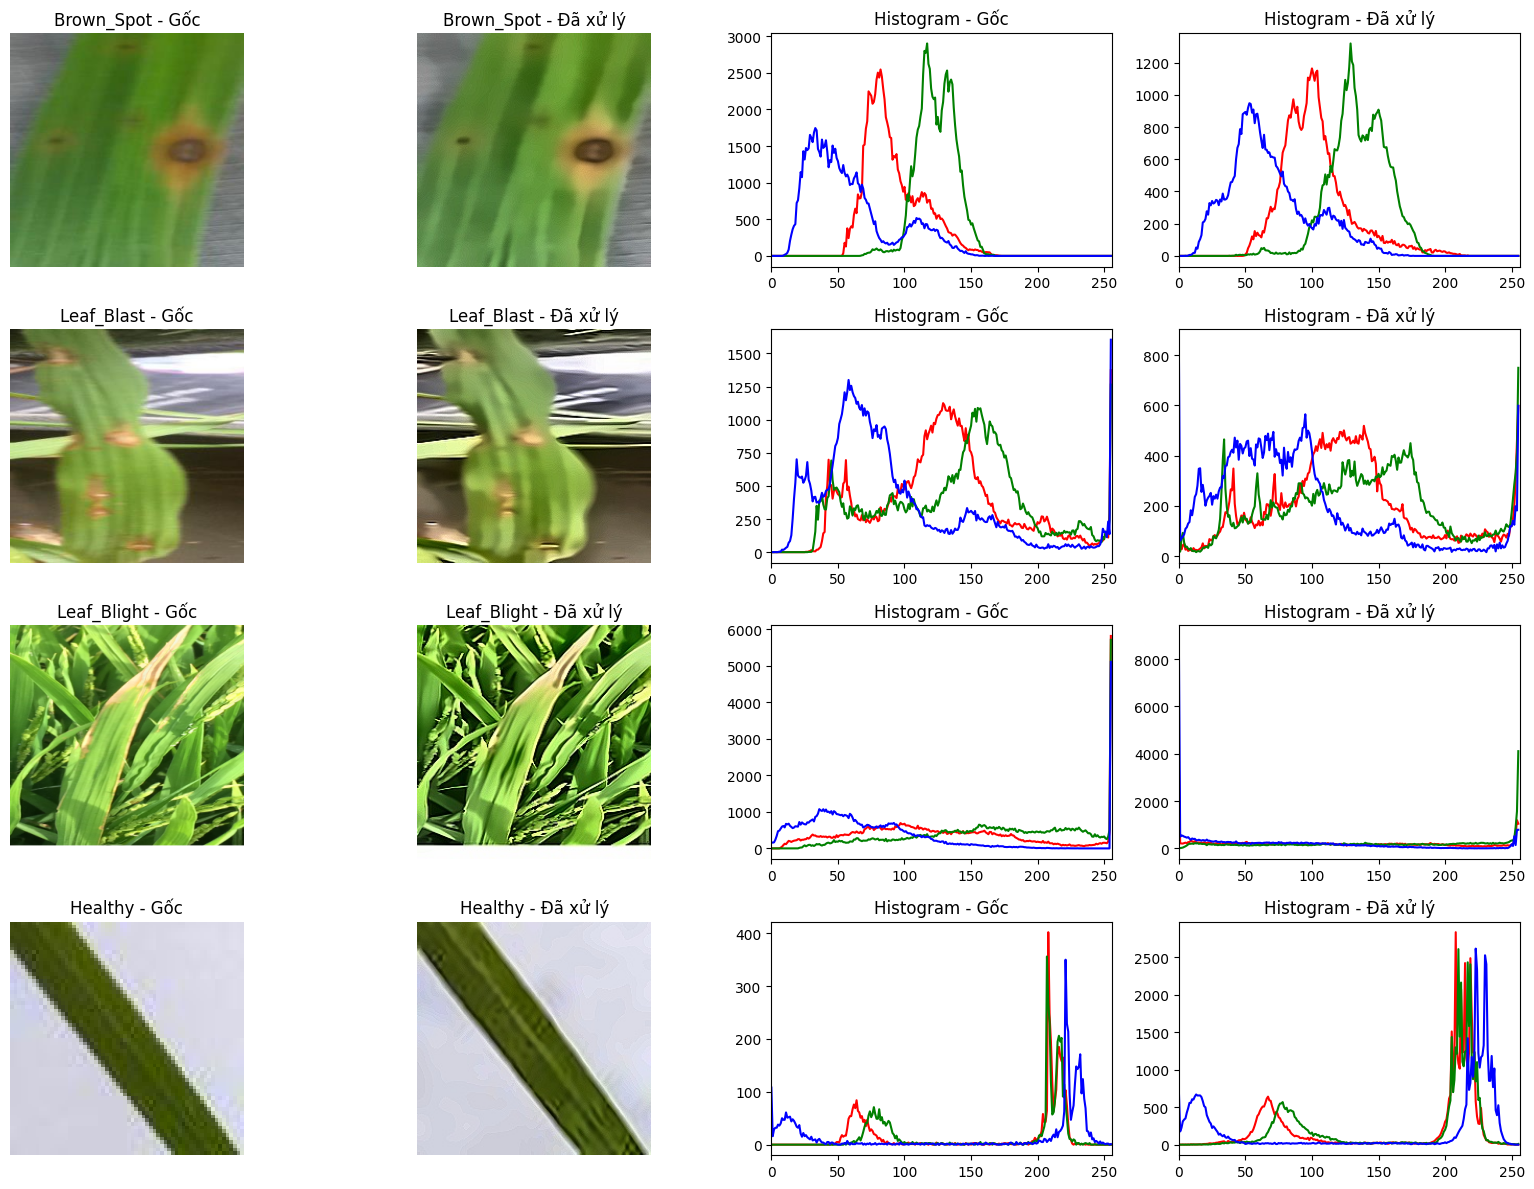

In [40]:
visualize_preprocessing()